# Detecting Tsunami-related Total Electron Content Anomalies in the Ionosphere with Convolutional Neural Networks

## Imports

In [1]:
import datetime
from datetime import timedelta
import fastai
from fastai.vision.all import *
import fastprogress
from hyperdash import monitor_cell, Experiment
import matplotlib.pyplot as plt
import natsort
import numpy as np
import os 
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from tqdm.notebook import tqdm

## Establish an Experiment

In [2]:
# Create an experiment with a model name, then autostart
exp = Experiment("Tsunami-related sTEC d/dt Anomaly Detection")

{ device_name: Tesla P100-SXM2-16GB }
{ data_path_train: /home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based_balanced/hawaii/train }
{ batch_size: 256 }
{ architecture: <function resnet34 at 0x70149e5c3268> }
{ learning_rate: 1e-05 }
{ parallel_gpus: False }
{ coverage_threshold: 0.9 }
{ epochs_max: 50 }
Better model found at epoch 0 with valid_loss value: 0.6363850235939026.
Better model found at epoch 1 with valid_loss value: 0.46305903792381287.
Better model found at epoch 4 with valid_loss value: 0.4624897837638855.
Better model found at epoch 5 with valid_loss value: 0.3375335931777954.
Better model found at epoch 6 with valid_loss value: 0.21781137585639954.
Better model found at epoch 8 with valid_loss value: 0.13056251406669617.
Better model found at epoch 9 with valid_loss value: 0.09182501584291458.
Better model found at epoch 10 with valid_loss value: 0.09006734937429428.
Better model found at epoch 11 with valid_loss value: 0.08178402483463287.
Better model

## Establishing CUDA device

In [3]:
# checking device number
assert torch.cuda.is_available()
index_device = torch.cuda.current_device()
device_name = exp.param("device_name", torch.cuda.get_device_name(index_device))

## Read Data

In [4]:
# set the data path 
data_path_train = "/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based_balanced/hawaii/train"
data_path_train = exp.param("data_path_train", data_path_train)
# data_path = "/u/scratch/s/stecproj/image_data/image_based/hawaii/train"

In [5]:
# set the batch size 
batch_size = 256
batch_size = exp.param("batch_size", batch_size)

In [6]:
# load in the data 
dls = ImageDataLoaders.from_folder(
    data_path_train, 
    item_tfms=Resize(224),
    valid_pct=0.2,
    bs=batch_size, #512, changed to 256 since my(Hamlin) GPU ran out of memory
    ds_tfms=aug_transforms(do_flip=True, flip_vert=True)
)

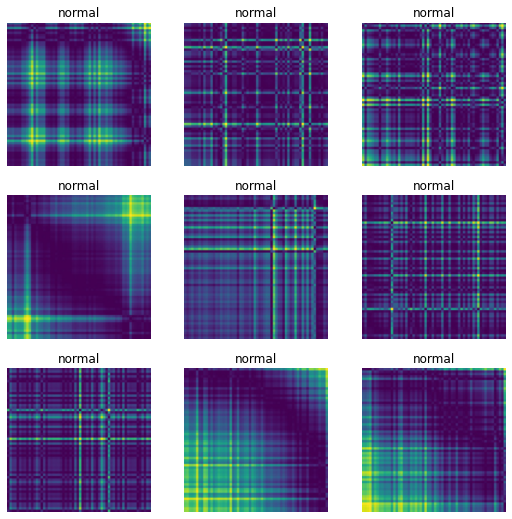

In [7]:
# show 9 sample images with correspond to our two labels in the dataset - normal and anomalous 
dls.show_batch()

In [8]:
# dls.dataset

In [9]:
# dls.dataset = dls.dataset.new(shuffle=False, sampler=ImbalancedDatasetSampler)

## Model Data

In [10]:
# define the learner 
architecture = resnet34

learn = cnn_learner(
    dls, # data
    architecture, # architecture 
    metrics=[error_rate, accuracy], # metrics
    pretrained=False, # whether or not to use transfer learning
    normalize=True, # this function adds a Normalization transform to the dls
#     callback_fns=[]
)

architecture = exp.param("architecture", architecture)

In [11]:
# learn.show_training_loop()

In [12]:
# for now, manually set the learning rate (automatic LR finders left for future work)
lr = 0.00001 # 0.00001 best result so far but not a given 
lr = exp.param("learning_rate", lr)

In [13]:
# parallel GPUs! Seems to work with squeezenet but not with resnet models (have not tried densenet, VGG or others)
parallel_gpus = False
# if torch.cuda.device_count() > 1:
#     parallel_gpus = True
#     learn.model = nn.DataParallel(learn.model)
parallel_gpus = exp.param("parallel_gpus", parallel_gpus)

## Metric functions

In [14]:
# set a threshold for calculating coverage
coverage_threshold = exp.param("coverage_threshold", 0.9)

In [15]:
def confusion_matrix_scores(cm: np.ndarray):
    """
    Returns a tuple of classification metrics according to
    the anomalous class as True Positive
    """
    accuracy = np.trace(cm)/np.sum(cm)
    total_anon = np.sum(cm[0]) if np.sum(cm[0]) > 0 else 1
    pred_anon = np.sum(cm[:, 0]) if np.sum(cm[:, 0]) > 0 else 1
    precision = cm[0, 0] / total_anon
    recall = cm[0, 0] / pred_anon
    denom = (precision + recall) if (precision + recall) > 0 else 1
    F1 = 2 * precision * recall / denom
    return accuracy, precision, recall, F1

def calculating_coverage(predictions: torch.Tensor, targets: torch.Tensor, threshold: float):
    """
    Given a N-sized validation set,
    predictions is an N x 2 tensor since this is a binary classification problem
    targes is an N x 1 tensor where each targets[i] is the correct class
    
    returns 2 tuple of all coverages of each class
    """
    anomalous = np.where(targets == 0)
    normal = np.where(targets == 1)
    normal_predictions = predictions[normal, 1]
    anomalous_predictions = predictions[anomalous, 0]
    anom_coverage = np.average(anomalous_predictions > threshold)
    normal_coverage = np.average(normal_predictions > threshold)
    return anom_coverage, normal_coverage
    

In [16]:
# max number of epochs
epochs_max = exp.param("epochs_max", 50)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.100628,0.636385,0.349343,0.650657,02:25
1,0.971343,0.463059,0.189982,0.810018,02:22
2,0.872006,0.470242,0.177688,0.822312,02:22
3,0.776732,0.485686,0.161729,0.838271,02:23
4,0.637101,0.462490,0.119349,0.880651,02:23
5,0.434144,0.337534,0.057040,0.942960,02:23
6,0.282227,0.217811,0.024053,0.975947,02:23
7,0.209685,0.257772,0.038485,0.961515,02:22
8,0.145340,0.130563,0.017410,0.982590,02:22
9,0.097970,0.091825,0.016035,0.983965,02:22


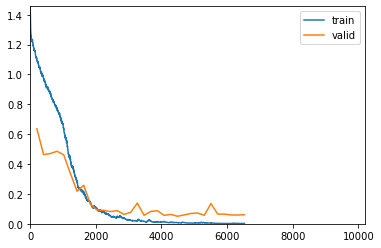

In [17]:
# Hyperdash API key: HaWsBsqUzqosfHQPw7XMSwl9l1gnGiUr05uydAzqxfo=

# set the parameters 
# TODO: size training
# TODO: size validation 
# TODO: size holdout 
# TODO: holdout channels (ground station, satellite combinations)
# TODO: pretrained 
# TODO: normalize 
# TODO: callbacks 

# train the model 
learn.fit(
    epochs_max, 
    lr=lr,
    cbs=[
        ShowGraphCallback(),
        CSVLogger(),
#         ParamScheduler(sched),
        ReduceLROnPlateau(
            monitor='valid_loss', 
            min_delta=0.001, 
            patience=5
        ),
        EarlyStoppingCallback(
            monitor="valid_loss",
            patience=10,
            min_delta=0.00001
        ),
        SaveModelCallback()
    ]
) 

# TODO: total training time 
# TODO: train loss, valid loss, error rate 


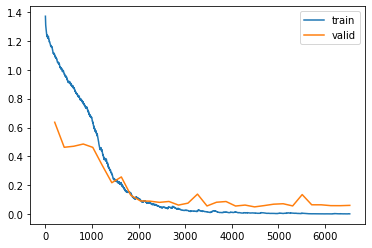

In [18]:
# plot the loss curve from model training
learn.recorder.plot_loss()

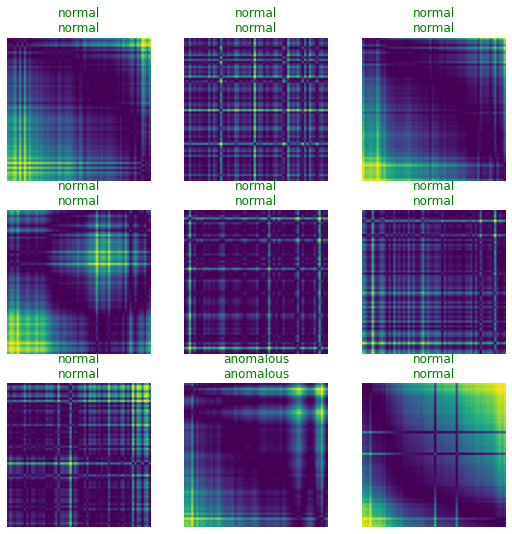

In [19]:
learn.show_results(max_n=9)

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

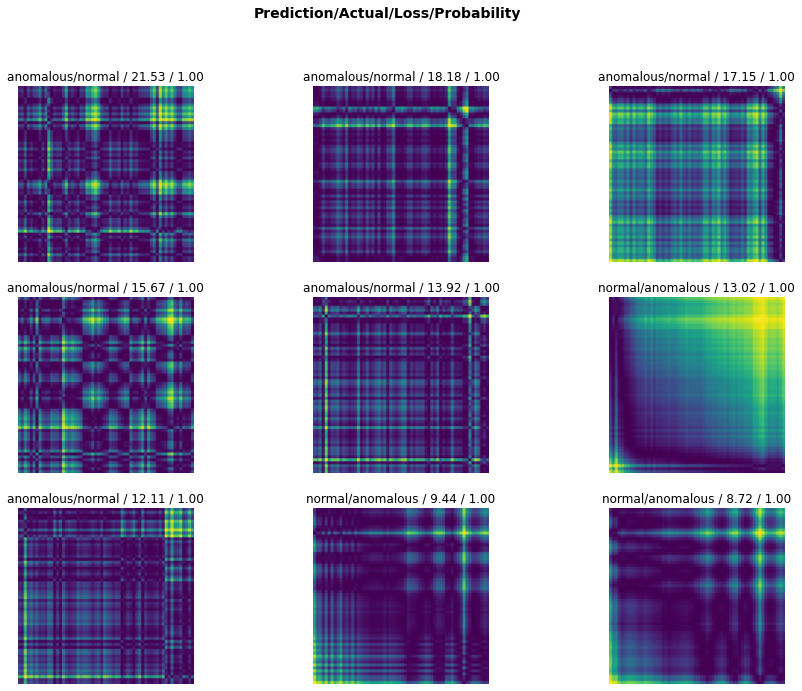

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

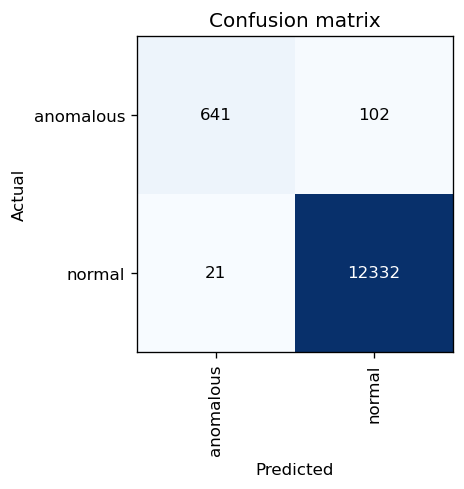

In [22]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [23]:
# interpret results from test set
interp = ClassificationInterpretation.from_learner(learn) 
cm = interp.confusion_matrix()

results = confusion_matrix_scores(cm)
accuracy = exp.metric("accuracy", results[0])
precision = exp.metric("precision", results[1])
recall = exp.metric("recall", results[2])
F1_score = exp.metric("F1 Score", results[3])


# coverage calculation
predictions, targets = learn.get_preds() #by default uses validation set
anom_cov, normal_cov = calculating_coverage(predictions, targets, coverage_threshold)
anomaly_cov = exp.metric("anomaly coverage", anom_cov)
normal_cov = exp.metric("normal coverage", normal_cov)


## Export and Save the Model

In [24]:
learn.export("../models/model.pkl") # TODO: clean up export path and where model saves history, etc. 

## TODO: Load in Saved Model

In [25]:
# learn = load_learner("../models/model.pkl")

### Real-World Experiment 

In [26]:
# set path for the validation set of data 
data_path_validation = "/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based_balanced/hawaii/validation"
# data_path_validation = exp.param("data_path_validation", data_path_validation)

In [27]:
# %%capture

def group_consecutives(vals, step=1):
    """Return list of consecutive lists of numbers from vals (number list).
    https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-in-a-numpy-array
    """
    run = []
    result = [run]
    expect = None
    for v in vals:
        if (v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    return result


# TODO: add typing for leerner
def real_world_simulation(data_path: str, learner, verbose: bool = False) -> None: 
    
    # define the annotations we use later for visualization and metrics reporting 
    sod_annotations = {
        "G04": 31400,
        "G07": 31160,
        "G08": 31900,
        "G10": 29900,
        "G20": 31150
    }
    
    # TODO: fix unintended printing from fastai
    with learner.no_bar():
                
        # disable logging 
        learner.no_logging()

        # first get all of the directories at the specified path 
        directories = os.listdir(data_path) # TODO: add validation to only pull directories not files 

        tp_tot = 0
        fn_tot = 0
        fp_tot = 0

        # now run predictions on each example in the data set
        for d in tqdm(directories): 
            
#             print(d)

            try:

                sat_name = d.split("__")[1]
                ground_station_name = d.split("__")[0]
                pass_id = ground_station_name + "__" + sat_name

                # get all of the image files from the day of the earthquake 
                # TODO: use all of the days not just the day of the earthquake for validation (depends on timing)

                # get all of the image paths in that directory for the day of the earthquake
                image_files = [f for f in natsort.natsorted(os.listdir(data_path + "/" + d + "/unlabeled")) if ".jpg" in f and "302" in f.split("_")[0]]

                # make predictions for all of the images from that day 
                # these were converted previously. In real world would need real-time conversion from float to image and 
                # then to classification 
                # for each image (window), predict and store the classification 
                classification = list()
                classification_confidence = list()
                windows = list()
                window_start = 0
                window_end = 60
                for img in image_files: 

                    try:

                        # load in the image and predict the classification 
                        prediction = learner.predict(data_path + "/" + d + "/unlabeled/" + img)

                        # store the classification and the window range 
                        classification.append(prediction[0])
                        classification_confidence.append(np.max(prediction[2].cpu().detach().numpy()))

                        windows.append([window_start, window_end])
                        window_start += 1
                        window_end += 1    
                    except:
                        print("Error encountered when predicting!")

                classification_bool = [0 if x == "normal" else 1 for x in classification]


                # store the classification result in a time-indexed array that is T minutes long by W windows tall 
                # the number of minutes T is the number of windows plus the window size, or window_end
                period_classification_df = pd.DataFrame(
                    index=list(range(0, len(image_files))),
                    columns=list(range(0, window_end - 1))
                ).astype(float)

                # note that this matrix can be used to classify anomalies with different weighting schemes
                # this is left for future work. We take the naive approach and say that any time index 
                # identified as anomaly is one 

                # and fill 
                index = 0
                for c, cc, w in zip(classification, classification_confidence, windows):
                    if c == "normal":
                        val = 0
                    else:
                        val = 1
                    period_classification_df.iloc[index, w[0]:w[1]] = val
                    index += 1


        #         if verbose is True: 

        #             # TODO: create a function for this and refactor a bit here
        #             # show this as a heatmap to explain concept 
        #             with sns.axes_style("darkgrid"):
        #                 plt.figure(figsize=(8, 10))
        #                 # mask = np.isnan(period_classification_df.astype(float).values)
        #                 # mask[np.triu_indices_from(mask)] = True
        #                 # ax = sns.heatmap(period_classification_df.astype(float), mask=mask)
        #                 ax = sns.heatmap(period_classification_df, cmap="viridis", cbar=True, cbar_kws={"shrink": .65})
        #                 plt.show()




                # now we need to load in the original data (float data) that contains the second of day 
                # and other data needed for visualization and metrics reporting 
                try:
                    sat = "../data/hawaii/2012/302/" + ground_station_name + "3020.12o_" + sat_name + ".txt"

                    f = open(sat, 'r')
                    line1 = f.readline()

                except:
                    print("Error reading float data!")

                line1 = line1.replace('#', '').replace("dsTEC/dt [TECU/s]", "dsTEC/dt").replace("elev", "ele")
                rename_cols = line1.split()
                rename_cols.remove("sod")
                new_cols = list()

                # rename the columns
                for rn_col in rename_cols:
                    new_col = pass_id + "_" + rn_col
                    if rn_col == "dsTEC/dt":
                        new_col = pass_id
                    new_cols.append(new_col)
                new_cols = ["sod"] + new_cols


                df = pd.read_table(
                    sat,
                    index_col='sod',
                    sep="\t\t| ",
                    names=new_cols,
                    engine="python",
                    skiprows=1
                )

                new_cols.remove('sod')

                sod = df.index
                timestamps = list()
                date = datetime(2012, 1, 1) + timedelta(302 - 1)

                for s in sod:

                    # hours, minutes, seconds
                    hours = int(s // 3600)
                    minutes = int((s % 3600) // 60)
                    seconds = int((s % 60))

                    # create a datetime object and append to the list
                    date_time = datetime(date.year, date.month, date.day, hours, minutes, seconds)
                    timestamps.append(date_time)


                df["timestamp"] = timestamps
                new_cols.append("timestamp")

                # now that we have read in the data, do some formatting 
                df = df[new_cols].reset_index()
                df["timestamp"] = pd.to_datetime(df["timestamp"])
                df.index = df["timestamp"]
                df = df.resample("1Min").mean()
            
                # identify continuous periods as we do when we generate the images and prep the data 
                events = np.split(df, np.where(np.isnan(df))[0])
                events = [ev[~np.isnan(ev)] for ev in events if not isinstance(ev, np.ndarray)]
                events = [ev.dropna() for ev in events if not ev.empty and ev.shape[0] > 100]

                # generate the normalized events in case we need them 
                normalized_events = list()
                for ev in events: 

                    # for each column in the data, rescale -1 to 1 
                    col_data = list()
                    for col in ev.columns.values:

                        normalized_data = minmax_scale(
                                    ev[col].dropna(), 
                                    feature_range=(-1, 1)
                                )
                        col_data.append(normalized_data)

                    df_period = pd.DataFrame(np.array(col_data).T, columns=list(ev.columns.values) )
                    df_period["timestamp"] = ev[col].index
                    df_period.index = df_period["timestamp"]
                    df_period = df_period.drop(columns=["timestamp"])

                    # convert to seconds of the day for later annotation 
                    df_period["sod"] = (df_period.index.hour*60+df_period.index.minute)*60 + df_period.index.second

                    normalized_events.append(df_period)


                #  # TODO: okay so now let's generate some metrics
                # like the code that generates the "events", we will determine the predicted 
                # sequence of anomalies and record whether or not they are true positives 

                # For simplicity, we do not make scoring adjustments based on
                # how early an anomaly was detected or the distance between false
                # positives and labeled regions

                ground_truth = [
                    sod_annotations[sat_name],
                    sod_annotations[sat_name] + (30 * 60) # 30 minutes 
                ]

                # for now assume events is length 1 # TODO fix later
                
                event = events[0].reset_index()
                
                ground_truth_sequence = event[(event["sod"] >= ground_truth[0]) & (event["sod"] <= ground_truth[1])].index.values
                
#                 print(df_ranges[(df_ranges["sod"] >= ground_truth[0]) & (df_ranges["sod"] <= ground_truth[1])]["sod"].values)
                
#                 print(ground_truth_sequence)
        
                adjusted_ground_truth_sequence = [x - 59 for x in ground_truth_sequence]
        
        
#                 print(adjusted_ground_truth_sequence)
                # NOTE the adjustment below for the window size 
                
                
#                 print(ground_truth_sequence.sample(frac=1).head(20))
                
                
                
                # get the indices of the anomalous values 
                anom_idx = np.where(np.array(classification_bool) == 1)
                
#                 print(anom_idx)
                
                anom_sequences = group_consecutives(list(anom_idx[0]))

                # A true positive is recorded if any portion of a predicted sequence of anomalies falls within any
                # true labeled sequence. Only one true positive is recorded
                # even if portions of multiple predicted sequences fall within
                # a labeled sequence.

                # If no predicted sequences overlap with a positively labeled
                # sequence, a false negative is recorded for the labeled sequence

                # For all predicted sequences that do not overlap a labeled
                # anomalous region, a false positive is recorded

                tp = 0
                fn = 0
                fp = 0

                # TODO: Hamlin please double check me on this 
                # NOTE: current code assumes one anomalous sequence 

                # check for false positives and true positives 
                for anom_seq in anom_sequences: 
                    
#                     print("\n-----------------")
#                     print(classification_bool)
#                     print(adjusted_ground_truth_sequence)
#                     print(anom_seq)
                    
                    intersection = list(set(adjusted_ground_truth_sequence) & set(anom_seq)) 
#                     print(intersection)
                    if len(intersection) > 0:
                        tp = 1 
                        fn = 0
                    else:
                        fp += 1
                        
                # check for false negatives 
                fn = 1
                for anom_seq in anom_sequences: 
                    intersection = list(set(adjusted_ground_truth_sequence) & set(anom_seq)) 
                    if len(intersection) > 0:
                        
                        fn = 0
                        break

                tp_tot += tp
                fn_tot += fn
                fp_tot += fp

                # make pretty plots! 
                if verbose: 

                    fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(12, 4))
                    fig.tight_layout()
                    fig.suptitle('Day of Earthquake Predictions by Second of Day (SoD) for ' + pass_id + "\n")

                    gs = plt.GridSpec(3, 1, height_ratios=[3, 1, 1]) 

                    axs[0] = plt.subplot(gs[0])
                    # NOTE the adjustment below for the window size 
                    sns.lineplot(data=events[0].iloc[59:, :], x="sod", y=pass_id, ax=axs[0])
                    axs[0].set(yticklabels=[]) 
                    axs[0].axvline(x=sod_annotations[sat_name], linestyle="dotted") # start 
                    axs[0].axvline(x=sod_annotations[sat_name] + (30 * 60), linestyle="dotted") # approx end - 30 minutes later 
                    #TODo: do we need to revisit data generation / labeling? 
                    axs[0].margins(x=0)
                    axs[0].set_xlabel("")

                    axs[1] = plt.subplot(gs[1])
                    sns.heatmap(np.array([classification_bool]), cbar=False, cmap="plasma", xticklabels=False, yticklabels=False, ax=axs[1])
                    axs[1].set_xlabel("Prediction (yellow is anomaly)") 

                    axs[2] = plt.subplot(gs[2])
                    sns.heatmap(np.array([classification_confidence]), cbar=False, cmap="plasma_r", xticklabels=False, yticklabels=False, ax=axs[2]) # .replace(0, np.nan)
                    axs[2].set_xlabel("Prediction Confidence (yellow is worse)") 


                    plt.subplots_adjust(left=0.125,
                                        bottom=0.1, 
                                        right=0.9, 
                                        top=0.9, 
                                        wspace=0.2, 
                                        hspace=0.5)

                    plt.show()

            except:
                print("ERROR: ", d)
                continue

#         print(tp_tot, fp_tot, fn_tot)
                
        try:
            precision = tp_tot / (tp_tot + fp_tot)
        except ZeroDivisionError:
            precision = 0.
            
        try:
            recall = tp_tot / (tp_tot + fn_tot)
        except ZeroDivisionError:
            recall = 0.
        try:
            f1_score = 2 * ((precision * recall) / (precision + recall))
        except ZeroDivisionError:
            f1_score = 0.
            
        precision = exp.metric("validation_precision", precision)
        recall = exp.metric("validation_recall", recall)
        f1_score = exp.metric("validation_f1_score", f1_score)
        



  0%|          | 0/33 [00:00<?, ?it/s]

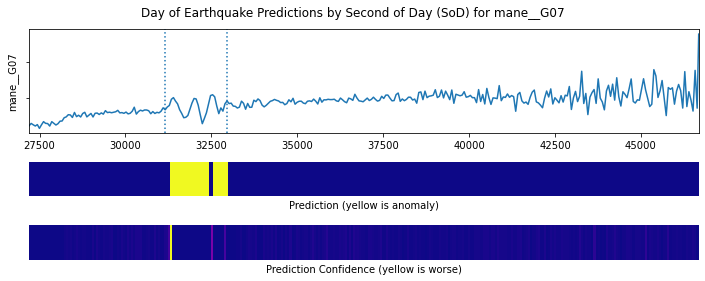

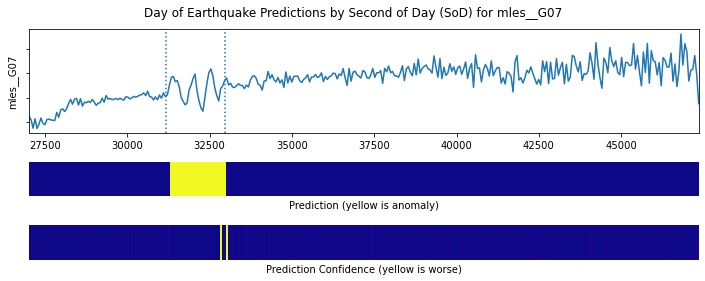

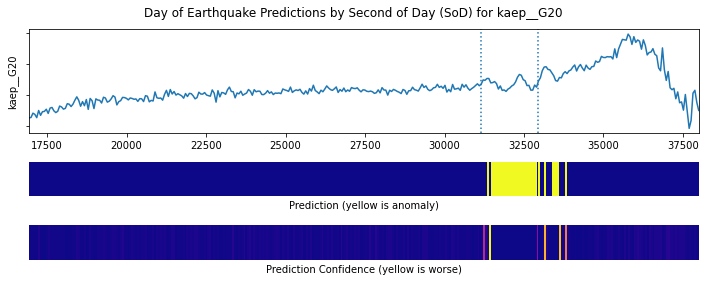

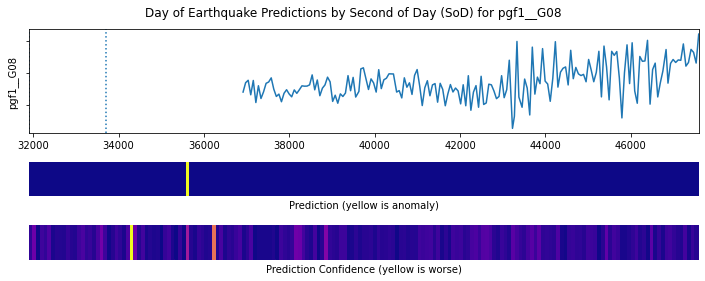

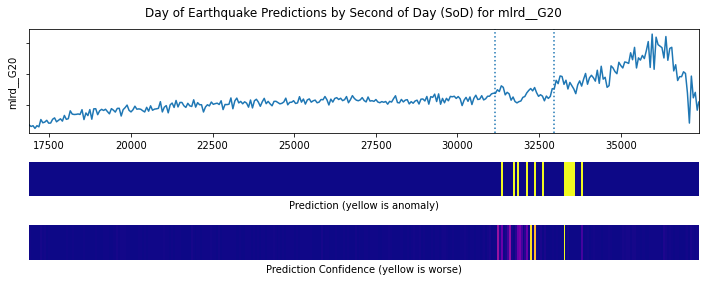

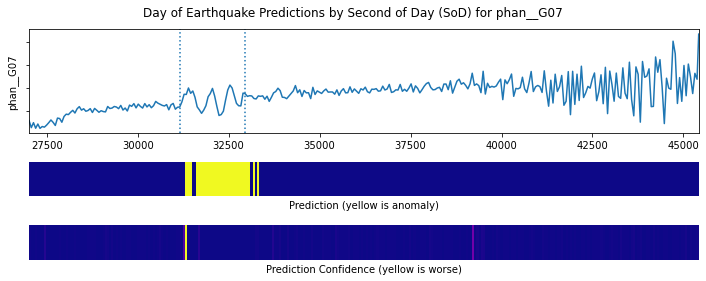

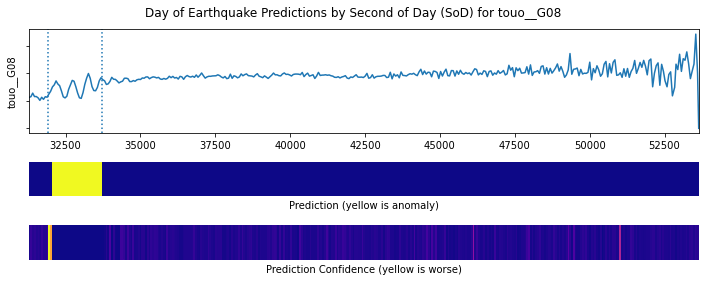

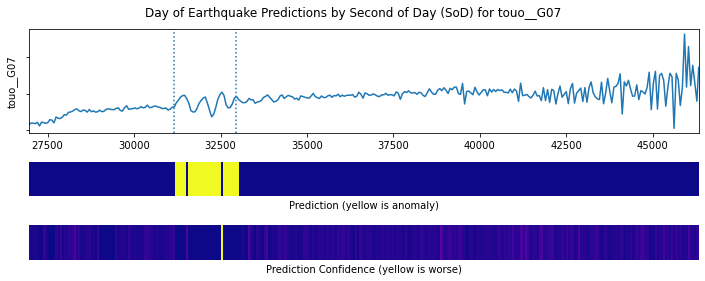

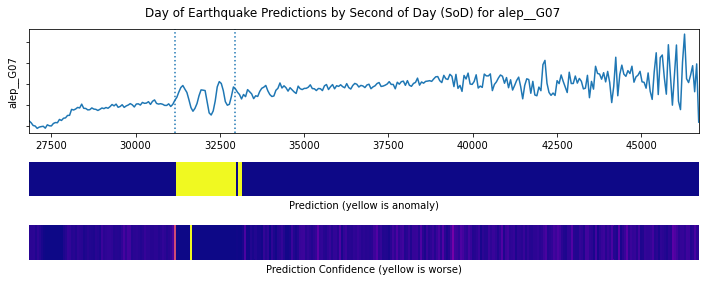

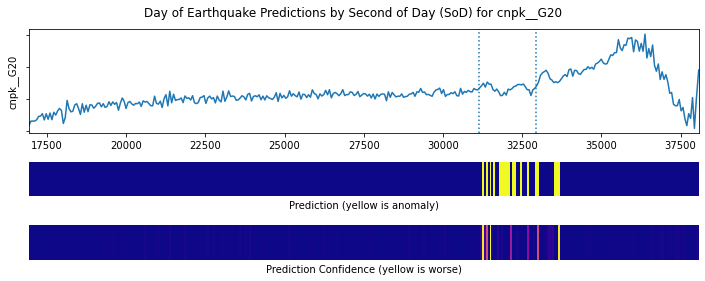

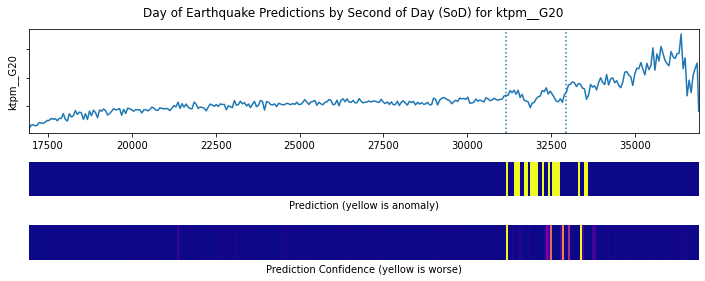

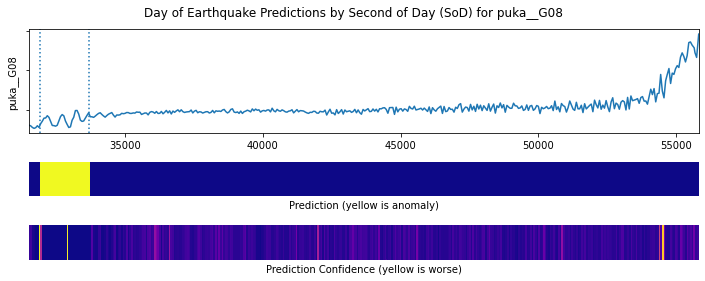

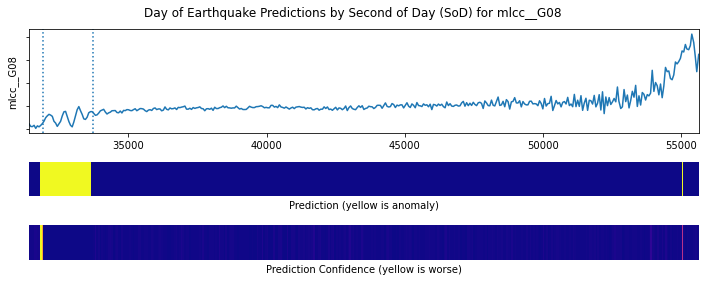

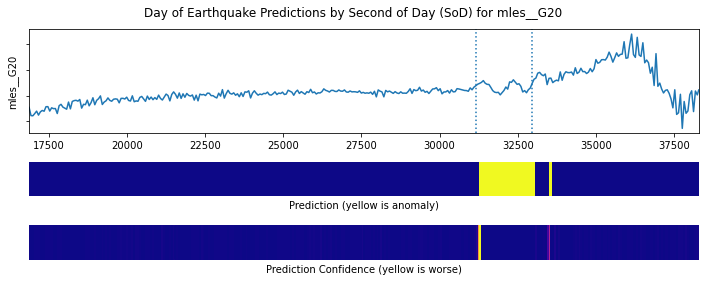

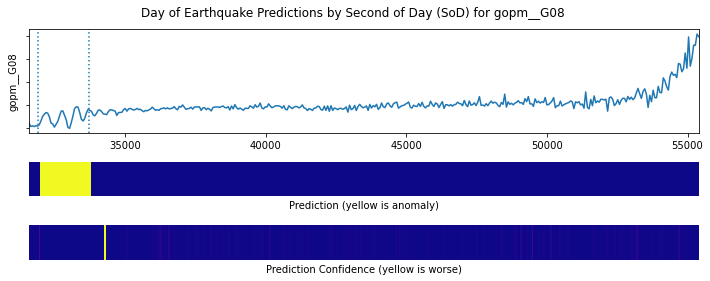

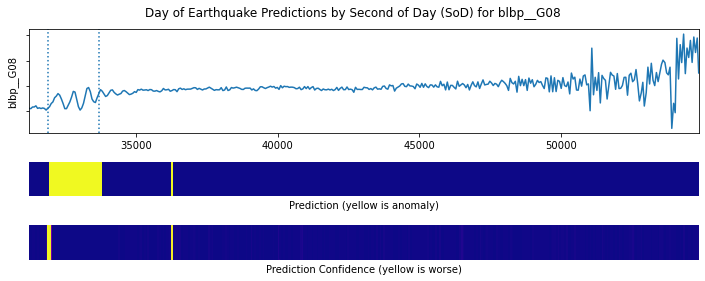

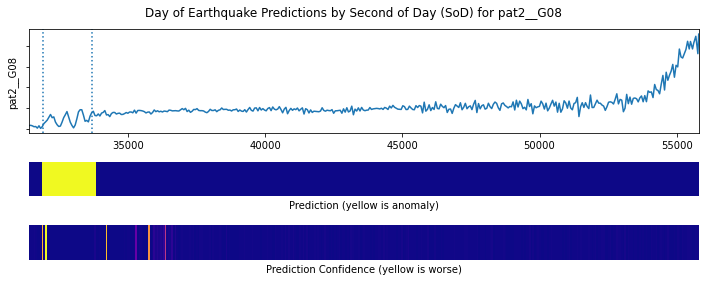

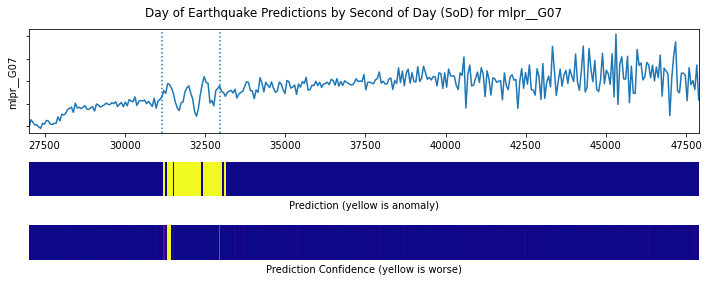

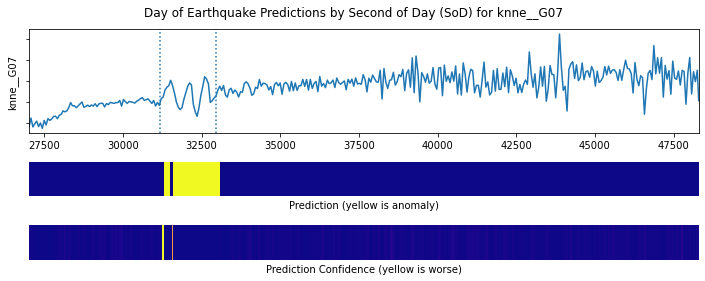

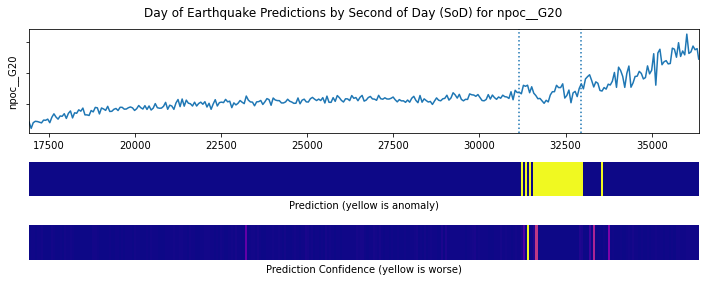

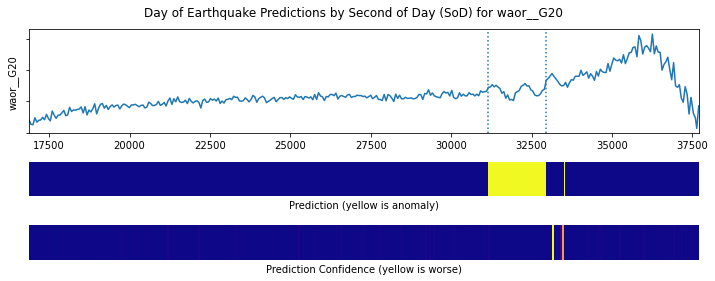

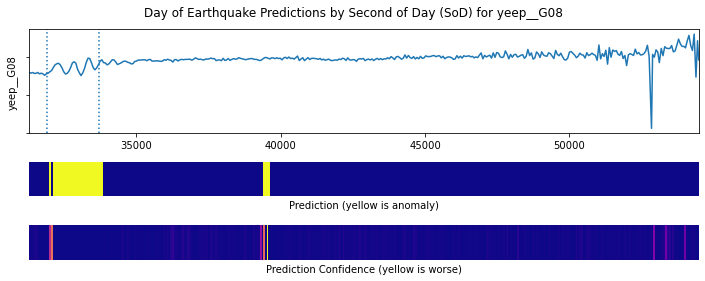

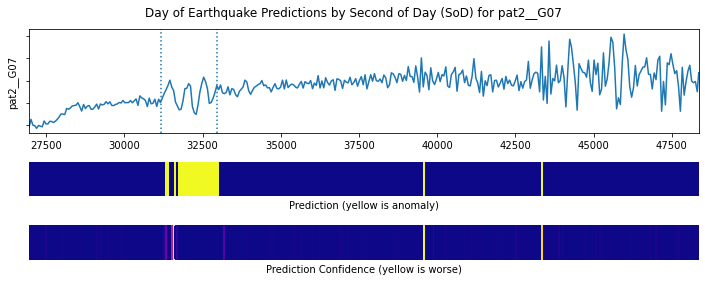

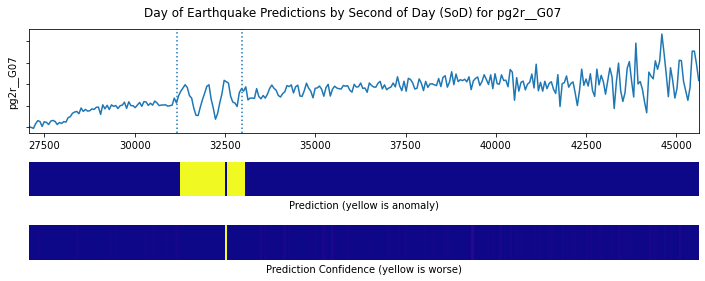

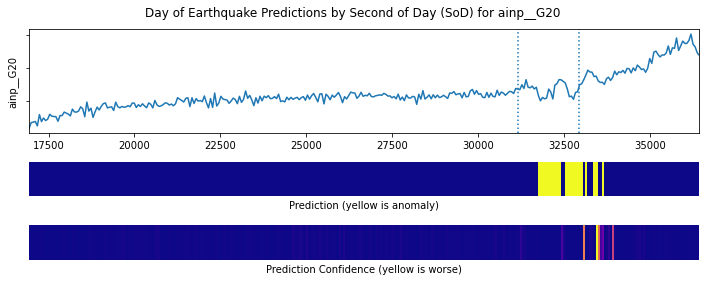

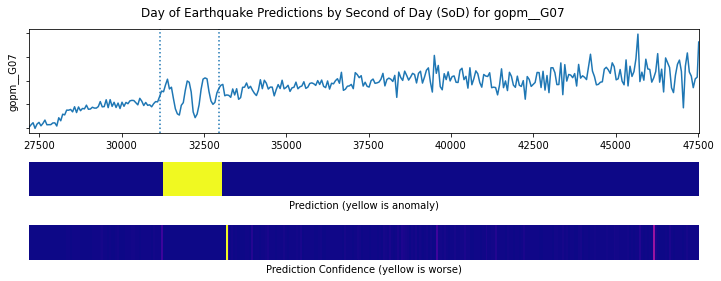

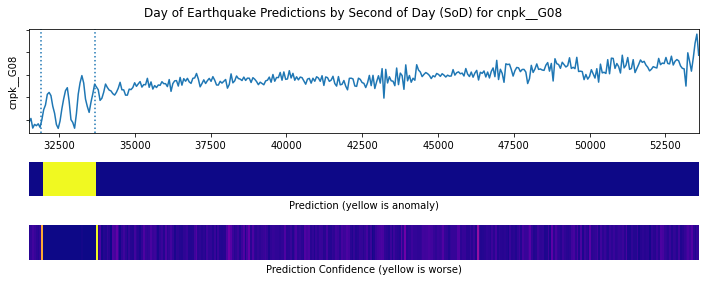

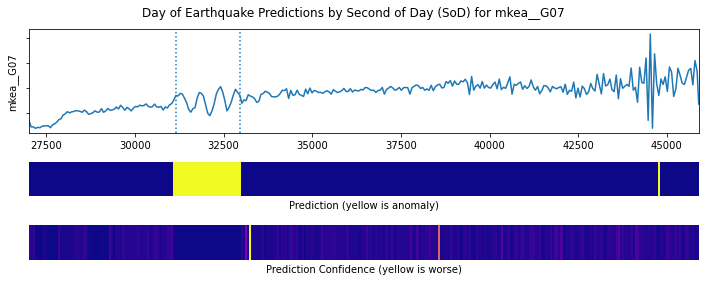

In [ ]:
real_world_simulation(
    data_path=data_path_validation,
    learner=learn,
    verbose=True
)

## End the Experiment

In [ ]:
# end the experiment 
exp.end()

### Below is older code that exists above and ought to be refactored and made nice 

In [ ]:
# work in progress. For now, building out base functionality with a single set of data in the validation set 
test_path = data_path_validation + "/kaep__G20/unlabeled/"

In [ ]:
# get all of the image paths in that directory for the day of the earthquake
image_files = [f for f in natsort.natsorted(os.listdir(test_path)) if ".jpg" in f and "302" in f.split("_")[0]]
image_files[0:10]

In [ ]:
# for each image (window), predict and store the classification 

classification = list()
classification_confidence = list()
windows = list()


window_start = 0
window_end = 60
for img in tqdm(image_files): 
    
    # load in the image and predict the classification 
    prediction = learn.predict(test_path + img)

    # store the classification and the window range 
    classification.append(prediction[0])
    classification_confidence.append(np.max(prediction[2].cpu().detach().numpy()))
    
    windows.append([window_start, window_end])
    window_start += 1
    window_end += 1    
    

In [ ]:
# store the classification result in a time-indexed array that is T minutes long by W windows tall 
# the number of minutes T is the number of windows plus the window size, or window_end
period_classification_df = pd.DataFrame(
    index=list(range(0, len(image_files))),
    columns=list(range(0, window_end - 1))
).astype(float)

# and fill 
index = 0
for c, cc, w in zip(classification, classification_confidence, windows):
    
    if c == "normal":
        val = 0
    else:
        val = 1
    
    period_classification_df.iloc[index, w[0]:w[1]] = val
    
    index += 1
    
period_classification_df

In [ ]:
sat_name = "G20"
ground_station_name = "kaep"
pass_id = ground_station_name + "__" + sat_name

sat = "../data/hawaii/2012/302/" + ground_station_name + "3020.12o_" + sat_name + ".txt"

f = open(sat, 'r')
line1 = f.readline()
line1 = line1.replace('#', '').replace("dsTEC/dt [TECU/s]", "dsTEC/dt").replace("elev", "ele")
rename_cols = line1.split()
rename_cols.remove("sod")
new_cols = list()

# rename the columns
for rn_col in rename_cols:
    new_col = pass_id + "_" + rn_col
    if rn_col == "dsTEC/dt":
        new_col = pass_id
    new_cols.append(new_col)
new_cols = ["sod"] + new_cols


df = pd.read_table(
    sat,
    index_col='sod',
    sep="\t\t| ",
    names=new_cols,
    engine="python",
    skiprows=1
)

new_cols.remove('sod')

sod = df.index
timestamps = list()
date = datetime(2012, 1, 1) + timedelta(302 - 1)

for s in sod:

    # hours, minutes, seconds
    hours = int(s // 3600)
    minutes = int((s % 3600) // 60)
    seconds = int((s % 60))

    # create a datetime object and append to the list
    date_time = datetime(date.year, date.month, date.day, hours, minutes, seconds)
    timestamps.append(date_time)


df["timestamp"] = timestamps
new_cols.append("timestamp")
    
df[new_cols].shape

In [ ]:
df = df[new_cols].reset_index()
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.index = df["timestamp"]
df = df.resample("1Min").mean()
df.head()

In [ ]:
df.shape

In [ ]:
events = np.split(df, np.where(np.isnan(df))[0])
    
events = [ev[~np.isnan(ev)] for ev in events if not isinstance(ev, np.ndarray)]
    
events = [ev.dropna() for ev in events if not ev.empty and ev.shape[0] > 100]

normalized_events = list()
for ev in events: 

    # for each column in the data, rescale -1 to 1 
    col_data = list()
    for col in ev.columns.values:

        normalized_data = minmax_scale(
                    ev[col].dropna(), 
                    feature_range=(-1, 1)
                )
        col_data.append(normalized_data)

    df_period = pd.DataFrame(np.array(col_data).T, columns=list(ev.columns.values) )
    df_period["timestamp"] = ev[col].index
    df_period.index = df_period["timestamp"]
    df_period = df_period.drop(columns=["timestamp"])

    # convert to seconds of the day for later annotation 
    df_period["sod"] = (df_period.index.hour*60+df_period.index.minute)*60 + df_period.index.second

    normalized_events.append(df_period)

In [ ]:
# to simulate the real world, we'll get the latest classification result for the newest time index 
# this means that the first indication is used for the overall classification 
# however, some slack could be built into the system taking a majority vote over the last N minutes. 
# introduces lag but could reduce false positives
# system will be built this way from the beginning. 

# normalized_events[0]
# events[0]



In [ ]:
# we assume the starts are the same... 

In [ ]:
sod_annotations = {
    "G04": 31400,
    "G07": 31160,
    "G08": 31900,
    "G10": 29900,
    "G20": 31150
}

In [ ]:
fig, axs = plt.subplots(3, sharex=False, sharey=False, figsize=(12, 4))

fig.tight_layout()

fig.suptitle('Day of Earthquake Predictions by Second of Day (SoD) for ' + pass_id + "\n")

gs = plt.GridSpec(3, 1, height_ratios=[3, 1, 1]) 


axs[0] = plt.subplot(gs[0])
sns.lineplot(data=events[0].iloc[59:, :], x="sod", y=pass_id, ax=axs[0])
axs[0].set(yticklabels=[]) 
axs[0].axvline(x=sod_annotations[sat_name], linestyle="dotted") # start 
axs[0].axvline(x=sod_annotations[sat_name] + (30 * 60), linestyle="dotted") # approx end - 30 minutes later 
#TODo: do we need to revisit data generation / labeling? 
axs[0].margins(x=0)
axs[0].set_xlabel("")

axs[1] = plt.subplot(gs[1])
classification_bool = [0 if x == "normal" else 1 for x in classification]
sns.heatmap(np.array([classification_bool]), cbar=False, cmap="plasma", xticklabels=False, yticklabels=False, ax=axs[1])
axs[1].set_xlabel("Prediction (yellow is anomaly)") 

axs[2] = plt.subplot(gs[2])
sns.heatmap(np.array([classification_confidence]), cbar=False, cmap="plasma_r", xticklabels=False, yticklabels=False, ax=axs[2]) # .replace(0, np.nan)
axs[2].set_xlabel("Prediction Confidence (yellow is worse)") 


plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)


plt.show()

In [ ]:
events[0].iloc[59:, :].shape

In [ ]:
period_classification_df.shape

In [ ]:
# plt.figure(figsize=(12, 1))
# ax = sns.heatmap(np.array([classification_confidence]), cbar=False, cmap="plasma_r", xticklabels=False, yticklabels=False)
# ax.set_xlabel("Prediction Confidence (yellow is worse)") 
# plt.show()

In [ ]:
# plt.figure(figsize=(12, 1))
# classification_bool = [0 if x == "normal" else 1 for x in classification]
# ax = sns.heatmap(np.array([classification_bool]), cbar=False, cmap="plasma", xticklabels=False, yticklabels=False)
# ax.set_xlabel("Prediction (yellow is anomaly)") 
# plt.show()

In [ ]:
# plt.figure(figsize=(12, 3))
# ax = sns.lineplot(data=events[0], x="sod", y="alep__G07")
# ax.set(yticklabels=[]) 
# ax.axvline(x=sod_annotations["G07"], linestyle="dotted") # start 
# ax.axvline(x=sod_annotations["G07"] + (30 * 60), linestyle="dotted") # approx end - 30 minutes later 
# #TODO: do we need to revisit data generation / labeling? 
# ax.margins(x=0)
# ax.set_xlabel("Second of Day (with anomaly start and approximate end times)")
# plt.show()



In [ ]:
# DONE: holdout recall, precision, accuracy, f-score,  as well 


# SCRATCH work
### To be deleted when requesting merge

In [ ]:
# clear cache and variables 
a = learn.get_preds()


In [ ]:
np.unique(np.argmax(a[0], axis=1))


In [ ]:
learn.metrics[1].__dict__

In [ ]:
dl = learn.dls[1]

In [ ]:
arr = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)

In [ ]:
arr

In [ ]:
z = interp.confusion_matrix()

In [ ]:
np.trace(z)/np.sum(z)

In [ ]:
np.sum(z[:, 0])

In [ ]:
learn.dls.loaders[1]

In [ ]:
dl

In [ ]:
cm = interp.confusion_matrix()
accuracy = np.trace(cm)/np.sum(cm)
total_anon = np.sum(cm[0]) if np.sum(cm[0]) > 0 else 1
pred_anon = np.sum(cm[:, 0]) if np.sum(cm[:, 0]) > 0 else 1
precision = cm[0, 0] / total_anon
recall = cm[0, 0] / pred_anon
denom = (precision + recall) if (precision + recall) > 0 else 1
F1 = 2 * precision * recall / denom

In [ ]:
F1

In [ ]:
cm

In [ ]:
dl = learn.dls[0]


In [ ]:
vars(dl)

In [ ]:
arr = learn.get_preds(dl=dl, with_input=True, with_loss=True, with_decoded=True, act=None)

In [ ]:
print(normal[4460])
len(normal)


In [ ]:
PIL.Image.open(anomalies[29])
PIL.Image.open(anomalies[29])
PIL.Image.open(normal[4460])

In [ ]:
anomalies = get_image_files(data_path + "pat2__G08/labeled/anomalous/")
normal = get_image_files(data_path + "pat2__G08/labeled/normal/")

In [ ]:
v, t = learn.get_preds()


In [ ]:
np.where(np.array(t) == 1)


In [ ]:
a

In [ ]:
predictions, targets = learn.get_preds()
anomalous = np.where(targets == 0)
normal = np.where(targets == 1)
normal_predictions = predictions[normal, 1]
anomalous_predictions = predictions[anomalous, 0]


In [ ]:
normal_predictions.shape

In [ ]:
np.average(normal_predictions > 0.9)

In [ ]:
type(predictions)

In [ ]:
a, b = calculating_coverage(predictions, targets, 0.9)

In [ ]:
a


In [ ]:
B

In [ ]:
b